## Code

In [1]:
from townsnet.engineering.engineering_model import EngineeringObject

ENG_OBJ_POTS = {
    EngineeringObject.ENGINEERING_OBJECT: [],
    EngineeringObject.POWER_PLANTS: [
        21, 33, 34, 35, 12
    ],
    EngineeringObject.WATER_INTAKE: [
        38, 40, 42
    ],
    EngineeringObject.WATER_TREATMENT: [
        37, 39, 14
    ],
    EngineeringObject.WATER_RESERVOIR: [
        45, 54, 55
    ],
    EngineeringObject.GAS_DISTRIBUTION: [
        13, 18, 59, 41, 56, 58
    ]
}

ENG_OBJ_INDICATOR = {
    EngineeringObject.ENGINEERING_OBJECT: 88,
    EngineeringObject.POWER_PLANTS: 89,
    EngineeringObject.WATER_INTAKE: 90,
    EngineeringObject.WATER_TREATMENT: 91,
    EngineeringObject.WATER_RESERVOIR: 92,
    EngineeringObject.GAS_DISTRIBUTION: 93
}

Physical objects fetch

In [2]:
import json
import requests
import geopandas as gpd
import shapely

URBAN_API = 'http://10.32.1.107:5300'
PAGE_SIZE = 10_000
DEFAULT_CRS = 4326

def _get_physical_objects(region_id: int, pot_id: int, page: int, page_size: int = PAGE_SIZE):
    res = requests.get(f'{URBAN_API}/api/v1/territory/{region_id}/physical_objects_with_geometry', {
        'physical_object_type_id': pot_id,
        'page': page,
        'page_size': page_size,
    }, verify=False)
    return res.json()

def get_physical_objects(region_id: int, pot_id: int) -> gpd.GeoDataFrame | None:
    page = 1
    results = []
    while True:
        res_json = _get_physical_objects(region_id, pot_id, page, page_size=PAGE_SIZE)
        results.extend(res_json['results'])
        if res_json['next'] is None:
            break
        page += 1
    # recovering geometries
    for result in results:
        g = result['geometry']
        result['geometry'] = shapely.from_geojson(json.dumps(g))
    if len(results) > 0:
        return gpd.GeoDataFrame(results, crs=DEFAULT_CRS).set_index('physical_object_id')
    return None

Territories fetch

In [3]:
import pandas as pd

def _get_territories(parent_id: int | None = None, all_levels=False,
                          geometry: bool = False) -> pd.DataFrame | gpd.GeoDataFrame:
    res = requests.get(URBAN_API + f'/api/v1/all_territories{"" if geometry else "_without_geometry"}', {
        'parent_id': parent_id,
        'get_all_levels': all_levels
    }, verify=False)
    if geometry:
        gdf = gpd.GeoDataFrame.from_features(res.json(), crs=DEFAULT_CRS)
        return gdf.set_index('territory_id', drop=True)
    df = pd.DataFrame(res.json())
    return df.set_index('territory_id', drop=True)

def _get_regions(geometry: bool = False) -> gpd.GeoDataFrame:
    countries = _get_territories()
    countries_ids = countries.index
    countries_regions = [_get_territories(country_id, geometry=geometry) for country_id in countries_ids]
    return pd.concat(countries_regions)

def fetch_units(region_id: int, level: int, crs : int) -> gpd.GeoDataFrame:
    if level == 2:  # return region gdf
        territories_gdf = _get_regions(True)
        territories_gdf = territories_gdf[territories_gdf.index == region_id]
    else:  # return certain gdf
        territories_gdf = _get_territories(region_id, all_levels=True, geometry=True)
        territories_gdf = territories_gdf[territories_gdf['level'] == level]
    return territories_gdf.to_crs(crs)

Model initializing

In [4]:
from townsnet.engineering.engineering_model import EngineeringModel
import pandas as pd
from tqdm import tqdm

def fetch_engineering_model(region_id : int, crs : int) -> EngineeringModel | None:
    eng_gdfs = {}
    for eng_obj, pots_ids in tqdm(ENG_OBJ_POTS.items()):
        pots_gdfs = []
        for pot_id in pots_ids:
            pot_gdf = get_physical_objects(region_id, pot_id)
            if pot_gdf is not None:
                pots_gdfs.append(pot_gdf)
        if len(pots_gdfs) > 0:
            eng_gdfs[eng_obj] = pd.concat(pots_gdfs).to_crs(crs)
    return EngineeringModel(eng_gdfs)

## Model

In [5]:
units = fetch_units(1,4, crs=32636)
model = fetch_engineering_model(1, crs=32636)

100%|██████████| 6/6 [00:17<00:00,  2.98s/it]


In [6]:
agg = model.aggregate(units)

In [7]:
agg

,geometry,Объект инженерной инфраструктуры,Электростанция,Водозабор,Водоочистительное сооружение,Водохранилище,Газораспределительная станция,assessment
territory_id,,,,,,,,
3,"POLYGON ((580049.515 6617067.72, 580225.344 66...",0,0,0,7,173,6,1
4,"POLYGON ((573514.444 6620389.851, 573579.919 6...",0,0,0,0,108,1,1
5,"POLYGON ((564707.328 6594903.594, 564341.814 6...",0,0,0,6,41,1,0
6,"POLYGON ((560629.509 6557332.762, 560642.857 6...",0,0,0,0,62,0,1
7,"POLYGON ((560659.317 6585430.874, 559919.213 6...",0,0,0,1,77,1,1
...,...,...,...,...,...,...,...,...
203,"POLYGON ((387941.398 6612286.59, 388009.665 66...",0,0,0,0,57,0,1
204,"POLYGON ((363803.737 6614904.469, 363821.597 6...",0,0,0,0,346,0,1
205,"POLYGON ((392924.072 6551507.217, 393174.409 6...",0,0,0,0,31,0,0


In [15]:
agg.groupby('assessment').size()

assessment
0    120
1     44
2      7
3     14
4      3
dtype: int64

In [16]:
agg

,geometry,Объект инженерной инфраструктуры,Электростанция,Водозабор,Водоочистительное сооружение,Водохранилище,Газораспределительная станция,assessment
territory_id,,,,,,,,
3,"POLYGON ((580049.515 6617067.72, 580225.344 66...",0,0,0,7,173,6,1
4,"POLYGON ((573514.444 6620389.851, 573579.919 6...",0,0,0,0,108,1,1
5,"POLYGON ((564707.328 6594903.594, 564341.814 6...",0,0,0,6,41,1,0
6,"POLYGON ((560629.509 6557332.762, 560642.857 6...",0,0,0,0,62,0,1
7,"POLYGON ((560659.317 6585430.874, 559919.213 6...",0,0,0,1,77,1,1
...,...,...,...,...,...,...,...,...
203,"POLYGON ((387941.398 6612286.59, 388009.665 66...",0,0,0,0,57,0,1
204,"POLYGON ((363803.737 6614904.469, 363821.597 6...",0,0,0,0,346,0,1
205,"POLYGON ((392924.072 6551507.217, 393174.409 6...",0,0,0,0,31,0,0


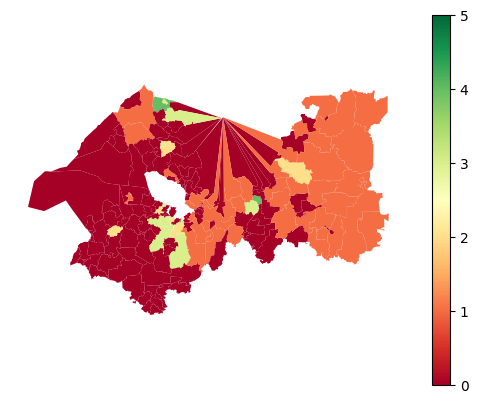

In [8]:
def get_assessment(df : pd.DataFrame):
  means = df.describe().loc['mean']

  def _get_assessment(series : pd.Series):
    assessment = 0
    for engineering_object in EngineeringObject:
      if engineering_object == EngineeringObject.ENGINEERING_OBJECT:
        continue
      mean_value = means[engineering_object.value]
      value = series[engineering_object.value]
      if  value >= mean_value:
        assessment += 1
    return assessment

  return df.apply(_get_assessment, axis=1)

agg['assessment'] = get_assessment(agg)
ax = agg.plot('assessment', legend=True, vmin=0, vmax=5, cmap='RdYlGn')
ax.set_axis_off()